# Description

As a first step, we need to explore and preprocess our data. The goal of this step is to prepare the data for applying clustering algorithms. The dataset contains metadata for all 45,000 movies listed in the Full MovieLens Dataset. It consists of movies released on or before July 2017. Data points include title, posters, backdrops, budget, revenue, release dates, languages, description, production countries, and companies.

Source: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv

# Import libraries

In [63]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.close('all')

In [64]:
# This is done to avoid seeing warnings in Jupyter Notebook

import warnings
warnings.filterwarnings('ignore')

# Basic exploration and preprocessing

In [65]:
# load and check a few rows of the data

df = pd.read_csv('../data/movies_metadata.csv')

df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


We see a lot of attributes that describe the movie. In this project, we are going to apply clustering algorithms on text data of the movie, so basically we need only two columns: its overview and title.

In [66]:
# leave the necessary columns

df = df[['overview', 'original_title']]

df.head()

,overview,original_title
0,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,When siblings Judy and Peter discover an encha...,Jumanji
2,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,Just when George Banks has recovered from his ...,Father of the Bride Part II


In [67]:
# check the basic info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overview        44512 non-null  object
 1   original_title  45466 non-null  object
dtypes: object(2)
memory usage: 710.5+ KB


We see that the column overview has 954 null values, so we need to drop those lines.

In [68]:
# drop lines with null values

df.dropna(axis=0, inplace=True)

# Text preprocessing

So we have the necessary data columns without null values. Now we need to prepare our text data. It contains: unify text, leave only alphabetic symbols, remove unnecessary spaces, tokenization, remove stop words, stemming.

In [70]:
# convert text to lowercase 

df['overview'] = df['overview'].str.lower()

In [71]:
# text cleaning 

def clean( text ):

    text = text.strip()

    available_symbols = "abcdefghijklmnopqrstuvwxyz "
    cleaned_text = [s for s in text if s in available_symbols]
    cleaned_text = ''.join(cleaned_text)
    
    while '  ' in cleaned_text:
        cleaned_text = cleaned_text.replace('  ', ' ')
    
    return cleaned_text


df['overview'] = df['overview'].apply( clean )

In [72]:
# tokenization and removing stop words

def remove_stop_words( text, sw ):

    tokens = text.split()
    tokens = [ token for token in tokens if token not in sw ]

    return tokens


sw = stopwords.words('english')
df['overview'] = df['overview'].apply( lambda text: remove_stop_words( text, sw ) )

In [73]:
# stemming

def stem( tokens, stemmer ):

    return [ stemmer.stem( token ) for token in tokens ]


stemmer = PorterStemmer()
df['overview'] = df['overview'].apply( lambda tokens: stem( tokens, stemmer ))

In [74]:
# check text data

df.head()

,overview,original_title
0,"[led, woodi, andi, toy, live, happili, room, a...",Toy Story
1,"[sibl, judi, peter, discov, enchant, board, ga...",Jumanji
2,"[famili, wed, reignit, ancient, feud, nextdoor...",Grumpier Old Men
3,"[cheat, mistreat, step, women, hold, breath, w...",Waiting to Exhale
4,"[georg, bank, recov, daughter, wed, receiv, ne...",Father of the Bride Part II


# Text data analysis

We already have cleaned our text data, so we need to explore basic information about them.

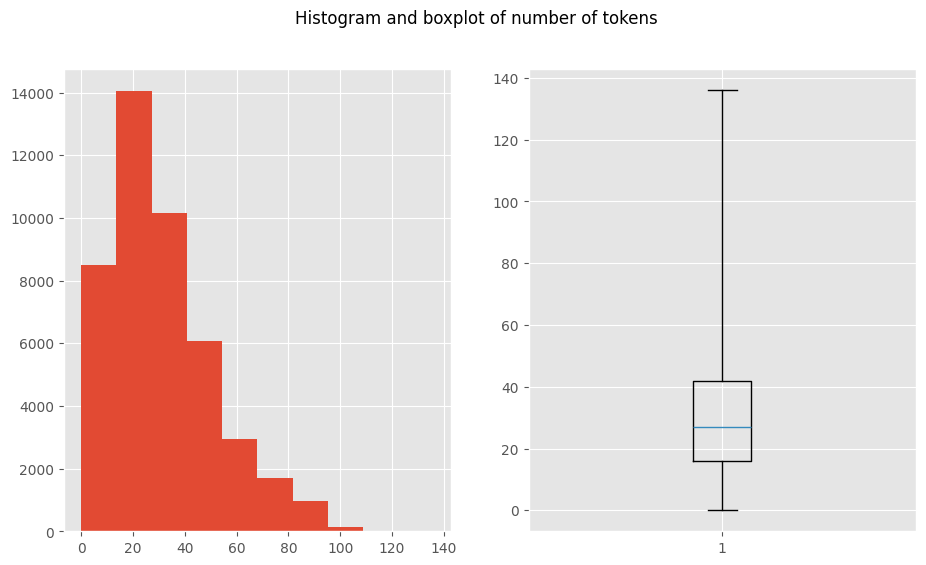

In [75]:
# count tokens histogram and boxplot 

df['count_tokens'] = df['overview'].apply( lambda tokens: len( tokens ) )


plt.figure( figsize=(11, 6) )
plt.suptitle('Histogram and boxplot of number of tokens')

plt.subplot(1, 2, 1)
plt.hist( df['count_tokens'] )

plt.subplot(1, 2, 2)
plt.boxplot( df['count_tokens'], whis=(0,100) )

plt.show()

We see that the median is ~27 tokens, and the majority of data has a count of tokens between 0 and 60. So we will observe in the feature how it influences clustering and whether this number of words in the film description will be sufficient to break down the data into clear clusters.

In [76]:
# number of unique words

texts = df['overview'].values.tolist()

unique_words = set()
for text in texts:
    for word in text:
        unique_words.add( word )

print(f'Number of unique words in data: {len(unique_words)}')

Number of unique words in data: 65744


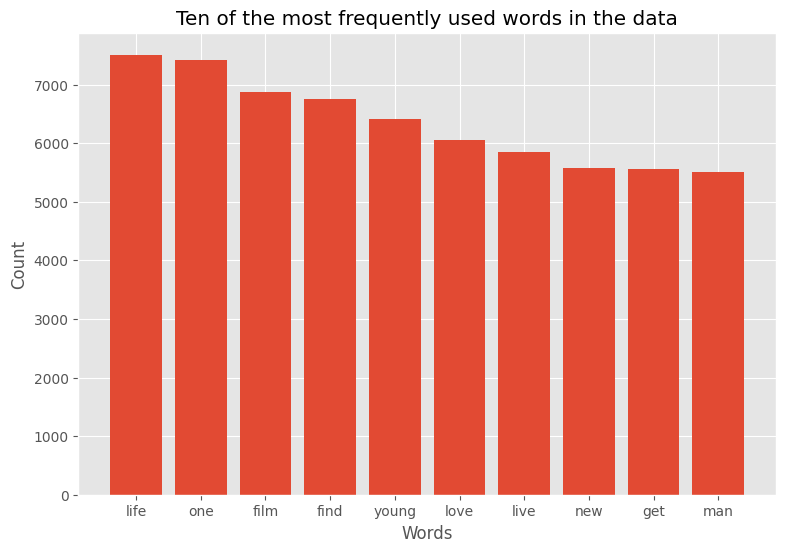

In [77]:
# top 10 most frequently used words

words_dictionary = {}

for text in texts:
    for word in text:

        if word not in words_dictionary:
            words_dictionary[word] = 0

        words_dictionary[word] += 1

sorted_words = sorted( words_dictionary.items(), key=lambda x: x[1], reverse=True )
most_frequently = dict(sorted_words[:10])

plt.figure( figsize=(9, 6) )
plt.bar(most_frequently.keys(), most_frequently.values())
plt.title('Ten of the most frequently used words in the data')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()


We see that the most frequent words don't give general information about the film; all of them are words that can appear in any film description. So in the vectorization step, using TfidfVectorizer will be better than the common CountVectorizer.

# Text vectorization

Before applying any machine learning algorithms, we should convert text data to numbers. Based on the previous analysis, we are going to use TfidfVectorizer, which takes into account the frequency of words in the data.

In [78]:
# vectorization of text

vectorizer = TfidfVectorizer()
vec_text_data = vectorizer.fit_transform( df['overview'].apply( lambda x: ' '.join(x) ) )

In [79]:
print(f'Shape of vectorizated text: {vec_text_data.shape}' )

Shape of vectorizated text: (44512, 65725)


# Reduction of dimensionality

Now we have a matrix with a huge shape, that has more features than data lines. So we need to reduce dimensionality before applying clustering algorithms. We are going to use one of the most common methods - PCA (Principal Component Analysis).

In [101]:
# applying reduction of dimensionality

pca = PCA( n_components=50 ).set_output(transform='pandas')
reduced_data = pca.fit_transform( vec_text_data )

In [102]:
# add a title column and overview for future using

reduced_data['title'] = df['original_title'].values
reduced_data['overview'] = df['overview'].values

In [103]:
reduced_data.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,title,overview
0,0.002984,0.017088,-0.008053,-0.015618,0.000522,0.000213,-0.021672,0.002338,-0.008547,-0.010627,0.002771,-0.022838,-0.029344,-0.003010,0.003380,-0.009963,-0.008607,-0.015081,-0.008042,0.015270,0.039758,0.013720,-0.008924,-0.010192,-0.003412,-0.000826,0.011264,-0.019151,-0.004525,-0.021938,0.008839,0.002920,-0.005231,0.006700,-0.001881,-0.001268,-0.004223,-0.007790,-0.004568,-0.008606,0.006932,0.004796,-0.011698,-0.004885,-0.010226,0.005412,0.004245,0.004462,0.008166,0.000514,Toy Story,"[led, woodi, andi, toy, live, happili, room, a..."
1,-0.007342,0.001979,-0.028812,-0.039937,0.044034,0.015186,0.029601,0.029650,0.036291,-0.005830,0.021658,-0.030512,-0.003691,0.004693,0.061517,-0.034029,-0.020992,0.035176,-0.053225,0.032243,0.060465,0.016683,-0.005110,0.031874,-0.003562,0.004509,-0.010195,-0.019986,-0.008059,-0.044121,-0.069649,0.049769,0.028217,-0.024358,0.007903,-0.018066,0.004989,0.016260,-0.013090,0.035649,-0.018106,0.065174,-0.047300,0.022166,0.004033,-0.025839,0.000177,-0.027209,-0.012381,-0.029778,Jumanji,"[sibl, judi, peter, discov, enchant, board, ga..."
2,-0.002010,-0.006120,-0.017088,-0.026439,0.009649,-0.029424,-0.051573,-0.027592,-0.028034,-0.020274,0.002724,0.008097,-0.007072,0.019068,0.006654,0.013811,0.040478,0.003420,0.003443,0.011467,0.004690,-0.018799,0.004721,0.007298,0.014500,0.009385,-0.002492,-0.003164,0.002900,-0.019249,0.016328,0.020321,-0.030448,0.002246,0.008556,0.005946,0.037228,-0.000755,-0.010227,-0.009973,0.023409,-0.011003,0.039339,-0.007257,-0.010975,0.007436,0.011366,-0.018861,-0.013601,-0.004551,Grumpier Old Men,"[famili, wed, reignit, ancient, feud, nextdoor..."


In [104]:
# save preprocessed data

reduced_data.to_csv('../data/preprocessed_data.csv', index=False)